In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [2]:
numQubits = 4   #No of qubits in the circuit
depth = 9       #calculated using d = numQubits*(depth+1)
d = 40          #No of parameters in the cicuit

In [3]:
dev = qml.device("default.qubit", wires=numQubits)   #"dev" device in pennylane

In [4]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [5]:
def add_layerRZ(data):                 #adds a layer of RZ gates
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def make_feature_map(data):           #"Easy" Feature map of the circuit
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    add_layerRZ(data)

In [6]:
def add_cnots():                      #Adds CNOTs between each pair of qubits
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):              #adds a layer of RY gates
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):    #Variational part of the circuit
    add_cnots()
    add_layerRY(params)

In [7]:
def make_final_circuit(data, params, depth):   #Makes the complete circuit
    make_feature_map(data)
    add_layerRY(params[0:numQubits])
    for i in range(depth):
        make_variationalCircuit(params[numQubits*(i+1):numQubits*(i+2)])

In [8]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params, depth)
    return qml.expval(qml.PauliX(1))

In [9]:
@qml.qnode(dev)
def fubini_qnode(data, params,depth):          #Returns the state of the circuit as a matrix
    make_final_circuit(data, params,depth)
    return qml.state()

In [10]:
def fubini_calculate(data, params,depth):     #calculates fubini matrix given the data vector and parameters
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params,depth))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [11]:
paramsVector = []

for i in range(50):
    np.random.seed(i)
    params = np.random.uniform(-1,1,d)
    paramsVector.append(params)

In [15]:
dataVector = []

for i in range(40):
    np.random.seed(i)
    data = np.random.normal(size=(numQubits))
    data = normalize(data)
    dataVector.append(data)

In [17]:
fubini_matrices = []
avg_fubini = []

eigen_vals = []
avg_eigen = []

In [ ]:
for i in range(50):
    print("data", i)
    params = paramsVector[i]
    sum_matrices = 0
    for j in range(len(dataVector)):
        print(j)
        data = dataVector[j]
        fubini = fubini_calculate(data, params, depth)
        fubini_matrices.append(fubini)
        
        sum_matrices += fubini
        eigvals,eigvecs=scipy.linalg.eigh(fubini)
        eigen_vals.append(eigvals)
    sum_matrices /= len(dataVector)
    avg_fubini.append(sum_matrices)
    
    eigvals_avg,eigvecs_avg=scipy.linalg.eigh(avg_fubini[i])
    avg_eigen.append(eigvals_avg)

data 0
0


In [18]:
len(avg_eigen)

50

In [19]:
import pickle
file_name = "EasyQuantumnormal1040.pkl"    #Saving data in a pickle file

open_file = open(file_name, "wb")
pickle.dump([paramsVector, dataVector,fubini_matrices, avg_fubini, eigen_vals, avg_eigen], open_file)
pickle.dump(fubini_matrices, open_file)
open_file.close()

In [20]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [21]:
len(loaded_list[5])

50

In [13]:
eigen_values = []
for i in range(len(eigen_vals)):
    for j in range(len(eigen_vals[0])):
        eigen_values.append(4*eigen_vals[i][j])       #Stores all the eigen_values, multiplication by 4 to match the Qiskit equivalent

In [14]:
len(eigen_values)

20000

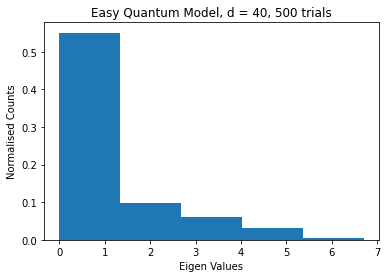

In [15]:
import matplotlib.pyplot as plt
plt.hist(eigen_values, bins = 5, density=True)
plt.title("Easy Quantum Model, d = 40, 500 trials")        #Eigen Values Distribution of 500 Fisher Matrices
plt.xlabel("Eigen Values")
plt.ylabel("Normalised Counts")
plt.savefig("EasyQuantum405001005")
plt.show()

In [16]:
import pickle

In [17]:
file_name = "EasyQuantum40500-10.pkl"    #Saving data in a pickle file

open_file = open(file_name, "wb")
pickle.dump([dataV,fubini_matrices,eigen_vals,paramsV,eigen_values], open_file)
pickle.dump(fubini_matrices, open_file)
open_file.close()

In [18]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [19]:
eigvals_bw01=[eigen_values[i] for i in range(len(eigen_values)) if eigen_values[i] <= 1]